In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import scipy.sparse.linalg
import torch
import torch.nn.functional as F
from torch.nn.functional import conv2d
import functools
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%load_ext autoreload

%autoreload 2

In [14]:
from crf.gaussian_matrix import LatticeGaussian, LSHGaussian

In [3]:
from crf.utils import read_image, read_pfm, read_pgm
from crf.features import Vgg16features
from crf.crf import *
from crf.depth import *

In [4]:
img1 = read_image('imL.png')#[::2,::2]
img2 = read_image('imR.png')#[::2,::2]
gt_depth = read_pgm('truedisp.row3.col3.pgm')
#img1 = read_image('im0.png')[::3,::3]
#img2 = read_image('im1.png')[::3,::3]
#gt_depth = read_pfm('disp0.pfm')[::3,::3]
device = torch.device('cpu')#torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
# Get random projection of VGG16 features
VGG = Vgg16features()
VGG.to(device)
features = VGG.get_all_features(img1)

/home/marc/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [6]:
q = 2
d=10
np_features = features[q]
projection_matrix = np.random.rand(np_features.shape[-1],d)
projected = np_features@projection_matrix
feats = (projected - projected.mean((0,1)))/projected.std((0,1))

In [7]:
## Hyper parameters
ws = 9      # Disparity aggregation window size
gamma = 3    # Charbonneir turning point
sigma_c = .1#.27#.1#.1 # Filter stdev for color channels
sigma_p = .1#.05#.1 # Filter stdev for position channels
sigma_f = 10#3.46#10 # Filter stdev for feature channels
n_iters = 30 # Number of mean field message passing iterations

In [8]:
# Get the unary potentials from window sweep
disp_energy = disparity_badness(img1,img2,ws,criterion=AD)
disps = np.argmin(disp_energy,axis=-1)
L = disp_energy.shape[-1] # Number of possible disparities
downsampled_out = disp_energy[::4,::4]
h,w,_ = downsampled_out.shape
n = h*w

E_0 = torch.from_numpy(downsampled_out.reshape(-1,L)).float().to(device)
P_0 = F.softmax(-E_0,dim=1)

In [9]:
# Setup the compatibility matrix
labels = torch.arange(L).float()
charb = lambda a,b: charbonneir(a,b,gamma)
Mu = compatibility_matrix(charb,labels).to(device)

In [15]:
# Calculate W matrix with brute force
position = np.mgrid[:h,:w].transpose((1,2,0))/np.sqrt(h**2+w**2)
ref = np.zeros((h,w,5+10))
ref[...,:3] = img1[::4,::4]/sigma_c
ref[...,3:5] = position/sigma_p
ref[...,5:] = feats[::4,::4]/sigma_f
flat_ref = torch.from_numpy(ref.reshape(n,-1).astype(np.float32))
#W = gaussian_weights_u(flat_ref.to(device))
# img_W = W.reshape((h,w,h,w))
W = LSHGaussian(flat_ref.to(device))

In [16]:
with torch.no_grad():
    mf = mean_field_infer(E_0,W,Mu,n_iters)
    expected_depths = mf@labels.to(device)#.max(dim=-1)[1]#@labels.to(device)
    crf_depth = expected_depths.reshape(h,w).cpu().numpy()
    baseline_depth = (P_0@labels.to(device)).reshape(h,w).cpu().numpy()

0
691
1382
2073
2764
3455
4146
4837
5528
6219
6910
0
691
1382
2073
2764
3455
4146
4837
5528
6219
6910
1605.951099537037
0.0


TypeError: rsub() received an invalid combination of arguments - got (Tensor, numpy.ndarray), but expected one of:
 * (Tensor input, Tensor other, Number alpha)
 * (Tensor input, Number other, Number alpha)


Text(0.5, 1.0, 'Ground Truth')

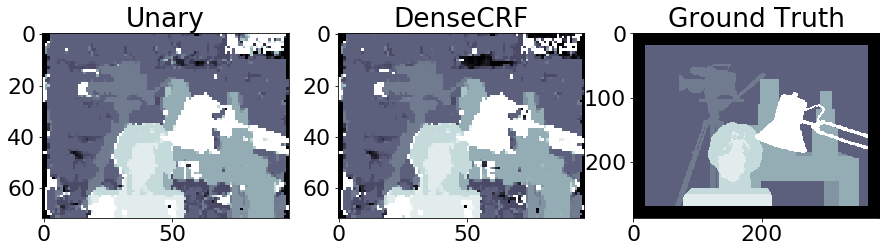

In [12]:
plt.rcParams.update({'font.size': 22})
f, axarr = plt.subplots(1,3,figsize=(15,10))
a0 = axarr[0].imshow(4*baseline_depth,cmap='bone',vmin=0,vmax=L)
a1 = axarr[1].imshow(4*crf_depth,cmap='bone',vmin=0,vmax=L)
a2 = axarr[2].imshow(gt_depth/4,cmap='bone',vmin=0,vmax=L)
axarr[0].set_title("Unary")
axarr[1].set_title("DenseCRF")
axarr[2].set_title("Ground Truth")

In [ ]:
plt.imshow(img1)
plt.show()

In [ ]:
featss = VGG.get_all_features(img1)

In [ ]:
for i in range(4):
    print(featss[i].shape)

In [ ]:
for d in range(4):
    ff  =featss[d]
    for i in range(ff.shape[-1]):
        plt.imshow(ff[:,:,i])
        plt.show()